In [1]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif


In [3]:
# Download the Kaggle dataset
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
DATASET_DIR = os.path.join(path, 'Aerial_Landscapes')

# Define the grid size for dividing the image (4x4)
GRID_SIZE = (4, 4)

# Parameters for Local Binary Pattern (LBP)
LBP_P = 24
LBP_R = 3

# Function to extract spatial LBP features from an image
def extract_spatial_lbp_features(image, grid_size=(4, 4)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    grid_h, grid_w = h // grid_size[0], w // grid_size[1]
    features = []
    
    # Iterate over each grid block in the image
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            block = gray[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            lbp = local_binary_pattern(block, P=LBP_P, R=LBP_R, method='uniform')
            hist, _ = np.histogram(lbp.ravel(),
                                   bins=np.arange(0, LBP_P + 3),
                                   range=(0, LBP_P + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            features.extend(hist)
    return features

# Load dataset and extract LBP features and labels
def load_data(dataset_path):
    X, y = [], []
    classes = sorted(os.listdir(dataset_path))
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.resize(img, (128, 128))  # Normalize size
            features = extract_spatial_lbp_features(img, grid_size=GRID_SIZE)
            X.append(features)
            y.append(class_name)
    return np.array(X), np.array(y)

X, y = load_data(DATASET_DIR)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=46, stratify=y_encoded)

Loading River: 100%|██████████| 800/800 [00:05<00:00, 144.77it/s]


In [4]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Apply PCA for dimensionality reduction
pca = PCA(n_components=34)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# Define KNN hyperparameter grid for tuning
param_grid_knn = {
    'n_neighbors': [i for i in range(1,31)], 
    'weights': ['distance', 'uniform'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV for hyperparameter tuning
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=10, verbose=2, n_jobs=-1)
grid_knn.fit(X_train_resampled, y_train_resampled)

# Output best parameters and model
print("Best Parameters:", grid_knn.best_params_)
best_model_knn = grid_knn.best_estimator_


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 27, 'p': 1, 'weights': 'distance'}


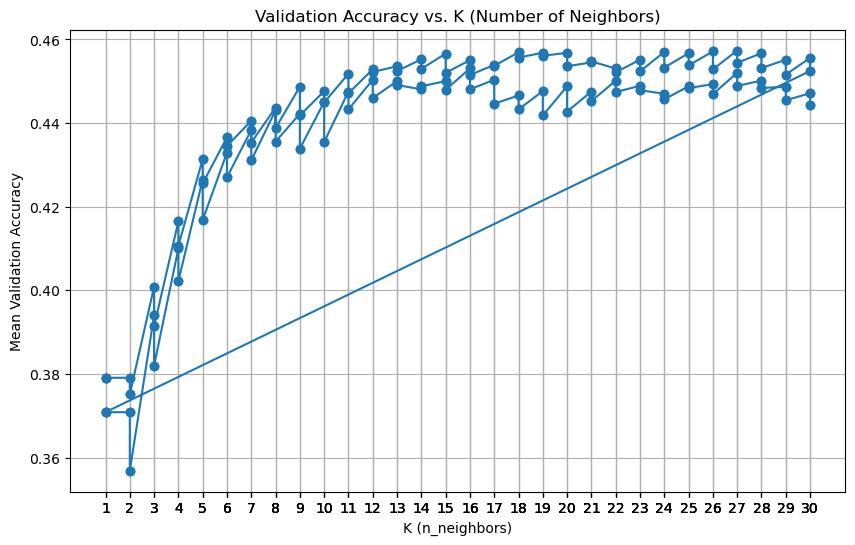

In [19]:
# Get k value and test scores
k_values = grid_knn.cv_results_['param_n_neighbors'].data
mean_test_scores = grid_knn.cv_results_['mean_test_score']

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='o')
plt.title("Validation Accuracy vs. K (Number of Neighbors)")
plt.xlabel("K (n_neighbors)")
plt.ylabel("Mean Validation Accuracy")
plt.grid(True)
plt.xticks(k_values[::2])  
plt.savefig("D:/postgraduate/comp9517/project/knn_vacc_vs_k.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Evaluation
y_pred = best_model_knn.predict(X_test_pca)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.4662
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.31      0.54      0.39       160
     Airport       0.34      0.26      0.30       160
       Beach       0.73      0.34      0.46       160
        City       0.30      0.33      0.31       160
      Desert       0.80      0.34      0.48       160
      Forest       0.59      0.76      0.66       160
   Grassland       0.63      0.68      0.65       160
     Highway       0.45      0.49      0.47       160
        Lake       0.77      0.44      0.56       160
    Mountain       0.45      0.63      0.53       160
     Parking       0.58      0.54      0.56       160
        Port       0.79      0.30      0.43       160
     Railway       0.50      0.44      0.47       160
 Residential       0.34      0.78      0.47       160
       River       0.21      0.11      0.15       160

    accuracy                           0.47      2400
   macro avg       0.52      0.47      0

In [6]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Confusion Matrix:
[[ 87   9   0   7   4   1   7   6   0   1   3   0   2  26   7]
 [ 22  42   0  15   0   1   0  11   2  16   3   3  17  14  14]
 [ 41  12  54  11   3   0   5   5   4   1   4   2   4   2  12]
 [  7   2   1  52   1   2   0   2   0  15   3   0   5  68   2]
 [ 28   5   2   2  55   4  19   0   2  23   6   1   7   1   5]
 [  0   2   0   0   0 121  17   1   0   2   3   0   4   9   1]
 [  7   1   0   1   2   9 109   4   0   2   8   1   5   9   2]
 [  7   5   2   9   0  14   3  79   0   2   9   0  11  18   1]
 [ 23   6   4  17   1   2   1   5  71  12   2   3   0   8   5]
 [ 10   2   0   9   0  12   1   2   0 101   1   0   3  17   2]
 [  3   2   0   5   0  18   6  11   0   3  87   2   1  22   0]
 [ 22   6   6   9   2   0   2   5  10   5  10  48   3  27   5]
 [  3  11   0   8   0  16   1  20   0  12   2   0  71   6  10]
 [  3   1   0  16   0   2   0   1   0   6   5   1   1 124   0]
 [ 22  18   5  13   1   4   3  23   3  22   3   0   8  17  18]]


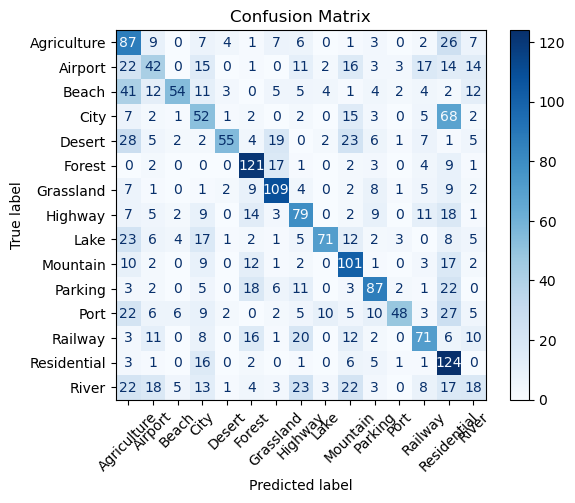

In [15]:
# Show confusion matrix
class_names=["Agriculture","Airport","Beach","City","Desert","Forest","Grassland","Highway","Lake","Mountain","Parking","Port","Railway","Residential","River"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig("D:/postgraduate/comp9517/project/knn_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Show training accuracy and difference
y_pred_train_knn = best_model_knn.predict(X_train_pca)
train_accuracy_knn = accuracy_score(y_train, y_pred_train_knn)
test_accuracy_knn = accuracy_score(y_test, y_pred)
print(f"KNN - Training accuracy: {train_accuracy_knn:.4f}, Test accuracy: {test_accuracy_knn:.4f}")
print(f"Difference: {train_accuracy_knn - test_accuracy_knn:.4f}")

KNN - Training accuracy: 1.0000, Test accuracy: 0.4662
Difference: 0.5337
